<a href="https://colab.research.google.com/github/bahargermany134-dotcom/U-Net-Denoising-on-CIFAR-10/blob/main/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import os

In [ ]:
import tarfile


#RAR FILE ROOT
tar_path = "/content/drive/MyDrive/cifar-10-python.tar.gz"
#File extract

with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall("/content/sample_data/")

#print extracted files

print("Files after extraction:", os.listdir("/content/sample_data/cifar-10-batches-py"))

/tmp/ipython-input-1214916073.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("/content/sample_data/")


Files after extraction: ['data_batch_1', 'batches.meta', 'data_batch_2', 'data_batch_4', 'data_batch_5', 'readme.html', 'data_batch_3', 'test_batch']


In [ ]:
import pickle
import os


data_dir = "/content/sample_data/cifar-10-batches-py"


def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

#
data_batch_1 = unpickle(os.path.join(data_dir, "data_batch_1"))
data_batch_2 = unpickle(os.path.join(data_dir, "data_batch_2"))
data_batch_3 = unpickle(os.path.join(data_dir, "data_batch_3"))
data_batch_4 = unpickle(os.path.join(data_dir, "data_batch_4"))
data_batch_5 = unpickle(os.path.join(data_dir, "data_batch_5"))

#
test_batch = unpickle(os.path.join(data_dir, "test_batch"))

# Loading Labels name
meta = unpickle(os.path.join(data_dir, "batches.meta"))
label_names = meta["label_names"]

print("labels:", label_names)
print("shape of data_batch_1['data']:", data_batch_1['data'].shape)
print("labels sample", data_batch_1['labels'][:10])


labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
shape of data_batch_1['data']: (10000, 3072)
labels sample [6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


In [ ]:

#concatenate train files
train_data = np.concatenate(
    [data_batch_1["data"],
     data_batch_2["data"],
     data_batch_3["data"],
     data_batch_4["data"],
     data_batch_5["data"]],
    axis=0
)
train_labels = np.concatenate(
    [data_batch_1["labels"],
     data_batch_2["labels"],
     data_batch_3["labels"],
     data_batch_4["labels"],
     data_batch_5["labels"]],
    axis=0
)

#test data

test_data = test_batch["data"]
test_labels = np.array(test_batch["labels"])

print("Train data shape:", train_data.shape)   # (50000, 3072)
print("Train labels shape:", train_labels.shape) # (50000,)
print("Test data shape:", test_data.shape)     # (10000, 3072)


Train data shape: (50000, 3072)
Train labels shape: (50000,)
Test data shape: (10000, 3072)


In [ ]:
#normalization
train_data=train_data.reshape(-1,3,32,32)
test_data=test_data.reshape(-1,3,32,32)

#[0,1]
train_data=train_data.astype('float32')/255.0
test_data=test_data.astype('float32')/255.0

print("train data shape after reshape"  ,  train_data.shape)
print("test data shape after reshape"  ,  test_data.shape)

train data shape after reshape (50000, 3, 32, 32)
test data shape after reshape (10000, 3, 32, 32)


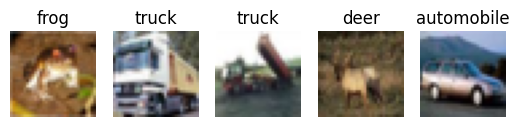

In [ ]:
#test of data set
import matplotlib.pyplot as plt


for i in range(5):
    img = train_data[i].transpose(1, 2, 0)  # از (3,32,32) به (32,32,3)
    label = label_names[train_labels[i]]
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.show()



In [ ]:
#add noise
def add_salt_paper_noise(img,prob=0.1):
  if img.shape[0]==3:
    img=img.transpose(1,2,0)

  noisy=np.copy(img)
  rnd=np.random.rand(*img.shape[:2])  #random mask on pixels

  #salt pixels (white=1)
  noisy[rnd<prob]=1

  #paper pixels (black=0)
  noisy[rnd>1-prob]=0

  return noisy.transpose(2,0,1)  #reshpe to (3,32,32)



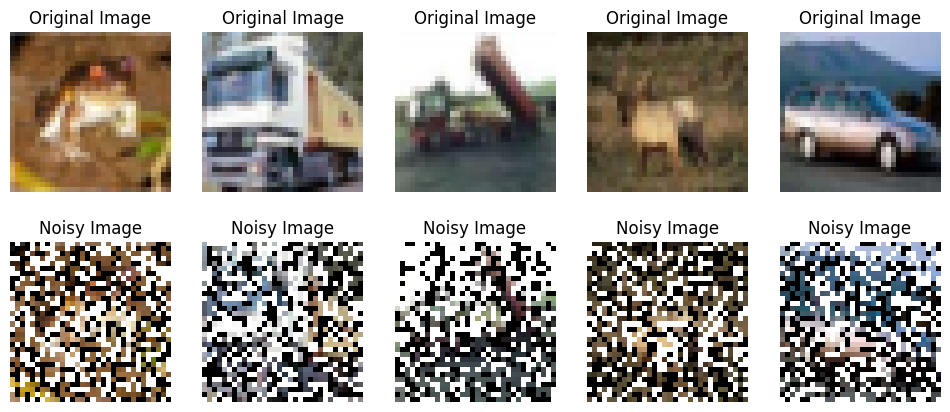

In [ ]:
#showing noisy and original images
fig, ax = plt.subplots(2,5,figsize=(12,5))

for i in range(5):
  clean=train_data[i]  #(3,32,32)
  noisy=add_salt_paper_noise(clean,prob=0.3)

  #original image
  ax[0,i].imshow(clean.transpose(1,2,0))
  ax[0,i].axis("off")
  ax[0,i].set_title("Original Image")

  #noisy image
  ax[1,i].imshow(noisy.transpose(1,2,0))
  ax[1,i].axis("off")
  ax[1,i].set_title("Noisy Image")

plt.show()

In [ ]:
############################UNET###############################
class DoubleConv(nn.Module):
  def __init__(self,in_ch,out_ch):
    super(DoubleConv,self).__init__()
    self.net=nn.Sequential(
        nn.Conv2d(in_ch,out_ch,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_ch,out_ch,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True)
    )


  def forward(self,x):
      return self.net(x)




class Down(nn.Module):
  def __init__(self,in_ch,out_ch):
    super(Down,self).__init__()
    self.pool=nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(in_ch,out_ch)
    )

  def forward(self,x):
    return self.pool(x)



class Up(nn.Module):
    def __init__(self,in_ch,out_ch,bilinear=True):
      super(Up,self).__init__()
      if bilinear:
        self.up=nn.Upsample(scale_factor=2,mode="bilinear",align_corners=True)
        self.conve=DoubleConv(in_ch,out_ch)
      else:
        self.up=nn.ConvTranspose2d(in_ch//2,in_ch//2,kernel_size=2,stride=2)
        self.conve=DoubleConv(in_ch,out_ch)

    def forward(self,x1,x2):
        x1=self.up(x1)
        #Pad
        diffx=x2.size()[2]-x1.size()[2]
        diffy=x2.size()[3]-x1.size()[3]
        x1=F.pad(x1,[diffx//2,diffx-diffx//2,diffy//2,diffy-diffy//2])
        x=torch.cat([x2,x1],dim=1)
        return self.conve(x)

class OutConv(nn.Module):
  def __init__(self,in_ch,out_ch):
    super(OutConv,self).__init__()
    self.conv=nn.Conv2d(in_ch,out_ch,kernel_size=1)

  def forward(self,x):
    return self.conv(x)

class UNET(nn.Module):
  def __init__(self,n_channels=3,n_classes=3,base_ch=16,bilinear=True):
    super(UNET,self).__init__()
    self.inc=DoubleConv(n_channels,base_ch)
    self.down1=Down(base_ch,base_ch*2)  #base_ch*2  32-->16
    self.down2=Down(base_ch*2,base_ch*4)  #base_ch*4  16-->8
    self.down3=Down(base_ch*4,base_ch*8)  #base_ch*8   8-->4

    factor=2 if bilinear else 1
    #self.down4=Down(base_ch*8,base_ch*16//factor)  #base_ch*16(1024)/2   4-->2
    self.up1  = Up(base_ch*8 + base_ch*4, base_ch*4, bilinear)   # 128+64=192 -> 64
    self.up2  = Up(base_ch*4 + base_ch*2, base_ch*2, bilinear)   # 64+32=96  -> 32
    self.up3  = Up(base_ch*2 + base_ch,     base_ch,   bilinear) # 32+16=48  -> 16
    self.outc = OutConv(base_ch, n_classes)
    #self.up4=Up(base_ch*2,base_ch,bilinear)
    #self.outc=OutConv(base_ch,n_classes)


  def forward(self,x):
    x1=self.inc(x)
    x2=self.down1(x1)
    x3=self.down2(x2)
    x4=self.down3(x3)
    #x5=self.down4(x4)
    x=self.up1(x4,x3)
    x=self.up2(x,x2)
    x=self.up3(x,x1)
   # x=self.up4(x,x1)
    x=self.outc(x)
    return torch.sigmoid(x)




In [ ]:
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
def salt_peper_noise_np(img_chw,prob=0.05,salt_vs_pepper=0.5):
   # img_chw: (C,H,W) in [0,1]
    c, h, w = img_chw.shape
    noisy = img_chw.copy()
    rnd = np.random.rand(h, w)

#pepper and salt
    p_salt = prob * salt_vs_pepper
    p_pepper = prob * (1.0 - salt_vs_pepper)

    salt_mask   = rnd < p_salt
    pepper_mask = rnd > (1.0 - p_pepper)

    for ch in range(c):
        noisy[ch, salt_mask]   = 1.0
        noisy[ch, pepper_mask] = 0.0
    return noisy

In [ ]:
class NumpyCIFAR10Denoise(Dataset):
  def __init__(self,clean_array,prob=0.05,salt_vs_peper=0.5):
    #clean_array:ndarray(  N,3,32,32)[0,1]
    self.clean=clean_array.astype(np.float32)
    self.prob=prob
    self.salt_vs_peper=salt_vs_peper


  def __len__(self):
      return len(self.clean)

  def __getitem__(self,idx):
      clean=self.clean[idx]
      noisy=salt_peper_noise_np(clean,self.prob,self.salt_vs_peper)
      # to tensor
      clean_t=torch.from_numpy(clean)
      noisy_t=torch.from_numpy(noisy)
      return noisy_t,clean_t


In [ ]:
#Data Loader
train_ds=NumpyCIFAR10Denoise(train_data,prob=0.05,salt_vs_peper=0.5)
test_ds=NumpyCIFAR10Denoise(test_data,prob=0.05,salt_vs_peper=0.5)

train_Loader=DataLoader(train_ds,batch_size=128,shuffle=True,num_workers=2,pin_memory=True)
test_Loader=DataLoader(test_ds,batch_size=128,shuffle=False,num_workers=2,pin_memory=True)

len(train_ds),len(test_ds)

(50000, 10000)

In [ ]:
#set seed
import math
def set_seed(seed=42):
  import random
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
def psnr_torch(x,y):
  mse=torch.mean((x-y)**2).item()
  if mse==0:
    return 99.0
  max_pixel=1.0
  psnr=20*math.log10(max_pixel/math.sqrt(mse))
  return psnr


In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:",device)

DEVICE: cpu


In [ ]:
model=UNET(n_channels=3,n_classes=3,base_ch=16,bilinear=True).to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
criterion=nn.MSELoss()


In [ ]:
model = UNET()
x = torch.randn(1,3,32,32)  # oneر CIFAR10 image
y = model(x)
print(y.shape)  # اexpection: (1,3,32,32)



torch.Size([1, 3, 32, 32])


In [ ]:
model=model.to(device)
criterion=nn.MSELoss().to(device)


In [ ]:
# ====================== data and model test======================
noisy, clean = next(iter(train_Loader))
noisy, clean = noisy.to(device), clean.to(device)

out = model(noisy)

print("noisy:", noisy.shape, noisy.min().item(), noisy.max().item())
print("clean:", clean.shape, clean.min().item(), clean.max().item())
print("out  :", out.shape, out.min().item(), out.max().item())

# ====================Loss test======================
#criterion = nn.L1Loss()
criterion=nn.MSELoss()
loss = criterion(out, clean)
print("Initial Loss:", loss.item())

# ====================Backward test======================
optimizer.zero_grad()
loss.backward()
optimizer.step()
print("✅ one step trainin was done")

# ====================== batch  print ======================
for i, (noisy, clean) in enumerate(train_Loader):
    noisy, clean = noisy.to(device), clean.to(device)
    out = model(noisy)
    loss = criterion(out, clean)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"batch {i}: loss={loss.item()}")
    if i == 3:  # only some first batch
        break


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


noisy: torch.Size([128, 3, 32, 32]) 0.0 1.0
clean: torch.Size([128, 3, 32, 32]) 0.0 1.0
out  : torch.Size([128, 3, 32, 32]) 0.048127494752407074 0.9352673292160034
Initial Loss: 0.07076240330934525
یک قدم آموزش انجام شد ✅
batch 0: loss=0.06610684096813202
batch 1: loss=0.06234531104564667
batch 2: loss=0.0663505420088768
batch 3: loss=0.06050998345017433


In [ ]:

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
epochs=5

for epoch in range(1, epochs+1):
    model.train()
    run_loss = 0.0
    for noisy, clean in train_Loader:
        noisy, clean = noisy.to(device), clean.to(device)
        den = model(noisy)
        loss = criterion(den, clean)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        run_loss += loss.item() * noisy.size(0)
    train_loss = run_loss / len(train_Loader.dataset)

    model.eval()
    val_run_loss = 0.0
    psnr_vals = []
    with torch.no_grad():
        for noisy, clean in test_Loader:
            noisy, clean = noisy.to(device), clean.to(device)
            den = model(noisy)
            loss = criterion(den, clean)
            val_run_loss += loss.item() * noisy.size(0)
            psnr_vals.append(psnr_torch(den.clamp(0,1), clean))
    val_loss = val_run_loss / len(test_Loader.dataset)
    val_psnr = sum(psnr_vals)/len(psnr_vals)

    scheduler.step(val_loss)
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_PSNR={val_psnr:.2f} dB")


Epoch 01 | train_loss=0.0052 | val_loss=0.0015 | val_PSNR=28.28 dB
Epoch 02 | train_loss=0.0013 | val_loss=0.0014 | val_PSNR=28.53 dB
Epoch 03 | train_loss=0.0009 | val_loss=0.0007 | val_PSNR=31.38 dB
Epoch 04 | train_loss=0.0008 | val_loss=0.0005 | val_PSNR=32.89 dB
Epoch 05 | train_loss=0.0006 | val_loss=0.0005 | val_PSNR=33.14 dB


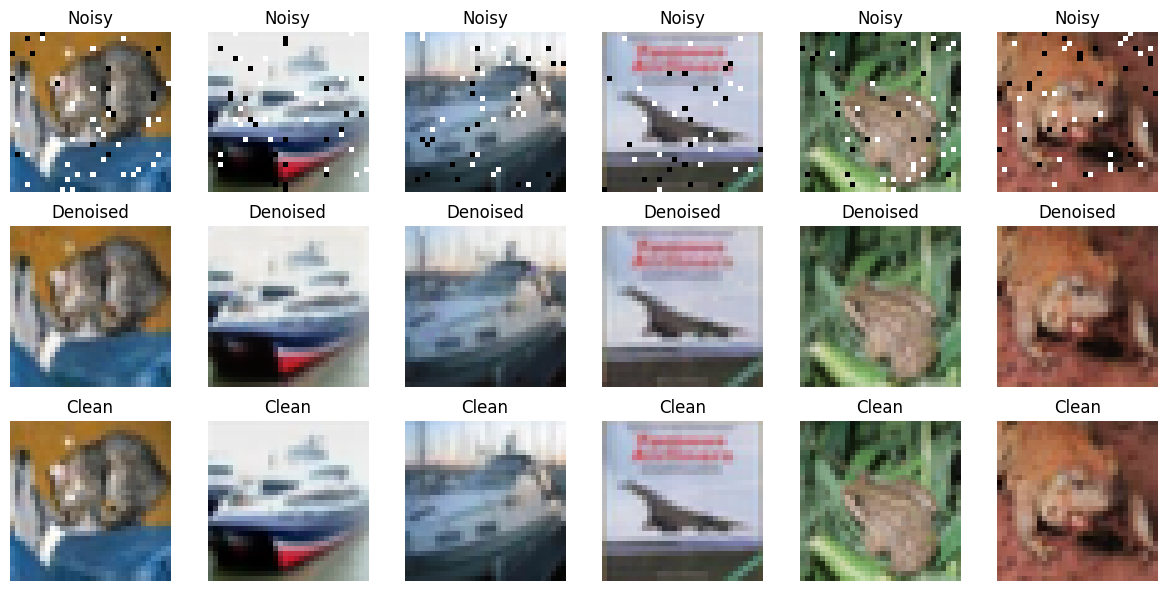

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    noisy_sample, clean_sample = next(iter(test_Loader))
    noisy_sample = noisy_sample.to(device)
    clean_sample = clean_sample.to(device)
    den_sample = model(noisy_sample).clamp(0,1)

#show some sample

n = 6
plt.figure(figsize=(12,6))
for i in range(n):
    # noisy
    plt.subplot(3, n, i+1)
    plt.imshow(noisy_sample[i].cpu().permute(1,2,0))
    plt.title("Noisy")
    plt.axis('off')

    # denoised
    plt.subplot(3, n, n+i+1)
    plt.imshow(den_sample[i].cpu().permute(1,2,0))
    plt.title("Denoised")
    plt.axis('off')

    # clean
    plt.subplot(3, n, 2*n+i+1)
    plt.imshow(clean_sample[i].cpu().permute(1,2,0))
    plt.title("Clean")
    plt.axis('off')
plt.tight_layout()
plt.show()
